# This notebook was run in Colab

## Installing required libraries

In [ ]:
!pip install torch torchvision
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# mount the google drive
from google.colab import drive
drive.mount('/content/gdrive')


In [ ]:
# Stance datasets are the english sentences from the CompSent-19 Dataset

df_train = pd.read_csv('gdrive/MyDrive/data/comparg_train.tsv', sep='\t', encoding='utf-8') #https://github.com/webis-de/ratio24-multilingual-cam/blob/ad8bd12cf7a8be235e689d4042641183212ab87c/data/compsent_train.tsv
df_test = pd.read_csv('gdrive/MyDrive/data/comparg_test.tsv', sep='\t', encoding='utf-8') #https://github.com/webis-de/ratio24-multilingual-cam/blob/ad8bd12cf7a8be235e689d4042641183212ab87c/data/compsent_test.tsv
df_russian = pd.read_csv('gdrive/MyDrive/data/ru_sentences_with_objs.tsv', sep='\t', encoding='utf-8') #https://github.com/webis-de/ratio24-multilingual-cam/blob/ad8bd12cf7a8be235e689d4042641183212ab87c/data/ru_sentences_with_objs.tsv


## Masking the comparison objects

In [ ]:
#masking the objects in the russian dataset:
#replacing the first object with "[FIRST_ENTITY]" and the second object with "[SECOND_ENTITY]" in every sample
import string

def mask_objects_ru(row):
    object_1 = row["Object1"].translate(str.maketrans('', '', string.punctuation))
    object_2 = row["Object2"].translate(str.maketrans('', '', string.punctuation))

    if len(object_1.split()) == 1 and len(object_2.split()) == 1:
      row["text"] = " ".join(["[FIRST_ENTITY]" if object_1.lower() in w.lower() else "[SECOND_ENTITY]" if object_2.lower() in w.lower() else w for w in row["text"].split()])

    elif len(object_1.split()) > 1 and len(object_2.split()) == 1:
      out = []
      for w in row["text"].split():
        for o1 in object_1.lower().split():
          if o1 in w.lower() and "[FIRST_ENTITY]" not in out and w.lower() not in [w.lower() for w in out]:
            out.append("[FIRST_ENTITY]")
            break
          elif object_2.lower() in w.lower() and "[SECOND_ENTITY]" not in out:
            out.append("[SECOND_ENTITY]")
            break
          else:
            if w.lower() not in [w.lower() for w in out] and w.lower() not in object_1.lower().split() and w.lower() not in object_2.lower().split():
              out.append(w)
      row["text"] = " ".join(out)

    elif len(object_1.split()) == 1 and len(object_2.split()) > 1:
      out = []
      for w in row["text"].split():
        for o2 in object_2.lower().split():
          if o2 in w.lower() and "[SECOND_ENTITY]" not in out and w.lower() not in [w.lower() for w in out]:
            out.append("[SECOND_ENTITY]")
            break
          elif object_1.lower() in w.lower() and "[FIRST_ENTITY]" not in out:
            out.append("[FIRST_ENTITY]")
            break
          else:
            if w.lower() not in [w.lower() for w in out] and w.lower() not in object_1.lower().split() and w.lower() not in object_2.lower().split():
              out.append(w)
      row["text"] = " ".join(out)

    else:
      row["text"] = row["text"].replace(object_1,"[FIRST_ENTITY]").replace(object_2,"[SECOND_ENTITY]")

    return row

def transform_data_ru(df):
  df = df.apply(mask_objects_ru,axis=1)
  return df

df_russian = transform_data_ru(df_russian)


In [ ]:
# mask objects in english datasets:
# replacing the first object with "[FIRST_ENTITY]" and the second object with "[SECOND_ENTITY]" in every sample
import re

def mask_objects(row):
    row["answer"] = re.sub(re.escape(row["object_0"]), "[FIRST_ENTITY]", row["answer"], flags=re.IGNORECASE)
    row["answer"] = re.sub(re.escape(row["object_1"]), "[SECOND_ENTITY]", row["answer"], flags=re.IGNORECASE)
    return row


def transform_data(df):
  df = df.apply(mask_objects,axis=1)
  return df


df_train = transform_data(df_train).sample(frac=1, random_state=42).reset_index(drop=True)
df_test = transform_data(df_test)




In [ ]:
# fix labels the labels (0,2,3) -> (0,1,2)
df_train['labels'] = df_train['labels'].replace({2: 1})
df_train['labels'] = df_train['labels'].replace({3: 2})
df_test['labels'] = df_test['labels'].replace({2: 1})
df_test['labels'] = df_test['labels'].replace({3: 2})
df_russian['tag'] = df_russian['tag'].replace({"NONE": 0})
df_russian['tag'] = df_russian['tag'].replace({"BETTER": 1})
df_russian['tag'] = df_russian['tag'].replace({"WORSE": 2})

df_train_ru, df_test_ru = train_test_split(df_russian, test_size=0.1, random_state=42)  #split russian dataset into russian trainset and testset (0.9,0.1)


In [ ]:
#preview of the full russian dataset (ru_full_dataset)
print(df_russian)

In [ ]:
#preview of the english trainset (en_train_dataset)
print(df_train)

<Axes: xlabel='tag'>

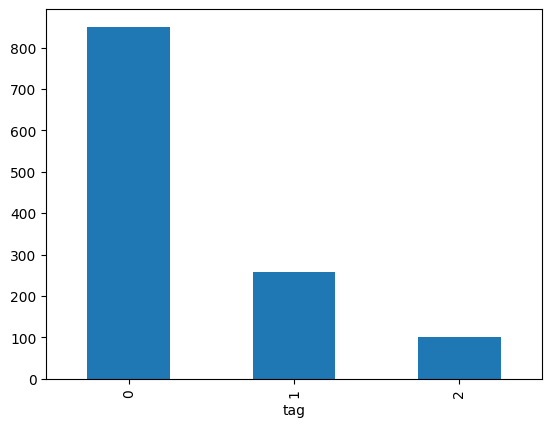

In [ ]:
#distribution of full russian dataset (ru_full_dataset)
df_russian['tag'].value_counts().sort_index().plot(kind='bar')

<Axes: xlabel='tag'>

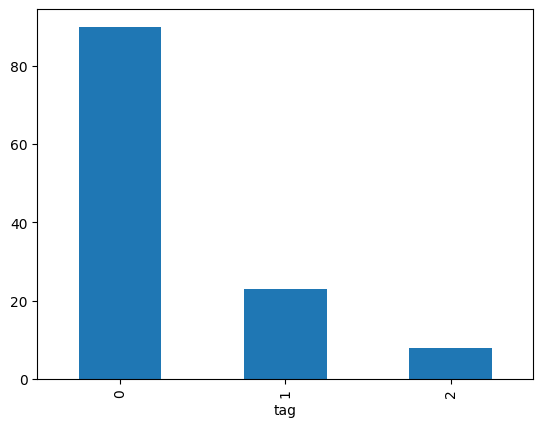

In [ ]:
#distribution of russian test dataset (ru_test_dataset)
df_test_ru['tag'].value_counts().sort_index().plot(kind='bar')

## Fine-tuning and evaluating XLM-RoBERTa

In [ ]:
from transformers import RobertaConfig, AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
#english dataframes to list as class CustomDataset takes lists as input
train_texts = df_train['answer'].tolist()
train_labels = df_train['labels'].tolist()
test_texts = df_test['answer'].tolist()
test_labels = df_test['labels'].tolist()




In [ ]:
#russian dataframes to list
test_ru_labels = df_test_ru['tag'].tolist()
test_ru_text = df_test_ru['text'].tolist()

ru_full_texts = df_russian['text'].tolist()
ru_full_labels = df_russian['tag'].tolist()


In [ ]:
xlm_tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-large')

In [ ]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = xlm_tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]


        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }





In [ ]:
max_length = 64
en_train_dataset = CustomDataset(train_texts, train_labels, xlm_tokenizer, max_length)
en_test_dataset = CustomDataset(test_texts, test_labels, xlm_tokenizer, max_length)
ru_test_dataset = CustomDataset(test_ru_text, test_ru_labels, xlm_tokenizer, max_length)
ru_full_dataset = CustomDataset(ru_full_texts, ru_full_labels, xlm_tokenizer, max_length)

In [ ]:
from transformers import set_seed
set_seed(42) #setting a seed for reproducability of weights
model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-large", num_labels=3)

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install accelerate -U #sometimes necessary to make the TrainingArguments work

In [ ]:
#the training arguments the model was trained with

from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

training_args = TrainingArguments(
    overwrite_output_dir=True,
    num_train_epochs=5,
    fp16=False,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,
    learning_rate=3e-5,
    output_dir = 'gdrive/MyDrive/xlm_roberta_checkpoints'
    )
data_collator = DataCollatorWithPadding(tokenizer=xlm_tokenizer)



In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_path = 'gdrive/MyDrive/finetuned/XLM_5epochs'
tokenizer = AutoTokenizer.from_pretrained(model_path)
xlm_5epochs = AutoModelForSequenceClassification.from_pretrained(model_path)  #loading our finetuned model


In [ ]:

trainer = Trainer(model = xlm_5epochs,
    args = training_args,
    train_dataset = en_train_dataset,
    data_collator = data_collator,
    tokenizer = xlm_tokenizer,)

#trainer.train() ...



In [ ]:
#Extending the Comparative Argumentative Machine: Multilingualism and Stance Detection, Table 1, XLM-RoBERTa_masked:
#Results on CompSent-19 testset (en_test_dataset) with XLM-RoBERTa trained on CompSent-19 trainset (en_train_dataset)
outputs_en = trainer.predict(en_test_dataset)

from sklearn.metrics import classification_report, f1_score
predictions_eng = outputs_en.predictions.argmax(-1)
target_names = ["neutral", "objekt1", "objekt2"]

print(classification_report(y_true=en_test_dataset.labels, y_pred=predictions_eng, target_names=target_names))
print(f"F1-micro: {f1_score(y_true=en_test_dataset.labels, y_pred=predictions_eng, average='micro')}")

              precision    recall  f1-score   support

     neutral       0.96      0.94      0.95      1048
     objekt1       0.87      0.88      0.87       273
     objekt2       0.65      0.73      0.69       119

    accuracy                           0.91      1440
   macro avg       0.82      0.85      0.84      1440
weighted avg       0.91      0.91      0.91      1440

F1-micro: 0.9104166666666667


In [ ]:
#save preds in csv
df_test['preds'] = predictions_eng
df_test.to_csv('gdrive/MyDrive/xlm_5epochs_preds_en.tsv', sep='\t', index=True)

In [ ]:
#Extending the Comparative Argumentative Machine: Multilingualism and Stance Detection, Table 2, XLM-RoBERTa_masked:
#Results on ru_full_dataset with XLM-RoBERTa trained on CompSent-19 trainset (en_train_dataset)
outputs_ru = trainer.predict(ru_full_dataset)
predictions_russian = outputs_ru.predictions.argmax(-1)
target_names = ["neutral", "objekt1", "objekt2"]

print(classification_report(y_true=ru_full_dataset.labels, y_pred=predictions_russian, target_names=target_names))
print(f"F1-micro: {f1_score(y_true=ru_full_dataset.labels, y_pred=predictions_russian, average='micro')}")

              precision    recall  f1-score   support

     neutral       0.86      0.95      0.90       850
     objekt1       0.80      0.59      0.68       257
     objekt2       0.58      0.50      0.53       101

    accuracy                           0.83      1208
   macro avg       0.75      0.68      0.71      1208
weighted avg       0.83      0.83      0.82      1208

F1-micro: 0.8327814569536425


In [ ]:
#save preds in csv
df_russian['preds'] = predictions_russian

output_file_path = 'gdrive/MyDrive/xlm_5epochs_preds_ru.tsv' #https://github.com/webis-de/ratio24-multilingual-cam/blob/ad8bd12cf7a8be235e689d4042641183212ab87c/results/stance_rus/xlm_5epochs_preds_ru.tsv
df_russian.to_csv(output_file_path, sep='\t', index=False)

In [ ]:
#Extending the Comparative Argumentative Machine: Multilingualism and Stance Detection, Table 2, XLM-RoBERTa_masked:
#Results on ru_test_dataset with XLM-RoBERTa trained on CompSent-19 trainset (en_train_dataset)
outputs_ru = trainer.predict(ru_test_dataset)
predictions_russian = outputs_ru.predictions.argmax(-1)
target_names = ["neutral", "objekt1", "objekt2"]

print(classification_report(y_true=ru_test_dataset.labels, y_pred=predictions_russian, target_names=target_names))
print(f"F1-micro: {f1_score(y_true=ru_test_dataset.labels, y_pred=predictions_russian, average='micro')}")

              precision    recall  f1-score   support

     neutral       0.86      0.96      0.91        90
     objekt1       0.81      0.57      0.67        23
     objekt2       0.80      0.50      0.62         8

    accuracy                           0.85       121
   macro avg       0.82      0.67      0.73       121
weighted avg       0.85      0.85      0.84       121

F1-micro: 0.8512396694214878


In [ ]:
#save preds in csv
df_test_ru['preds'] = predictions_russian

output_file_path = 'gdrive/MyDrive/xlm_5epochs_preds_ru_test.tsv'
df_test_ru.to_csv(output_file_path, sep='\t', index=False)

In [ ]:
# We noticed 49 samples were not masked correctly


df_test_russian_unfixed = df_russian
wrong_mask_russian =  df_test_russian_unfixed[df_test_russian_unfixed['text'].apply(lambda x: not ("[FIRST_ENTITY]" in x and "[SECOND_ENTITY]" in x))]
only_first_entity_russian =  df_test_russian_unfixed[df_test_russian_unfixed['text'].apply(lambda x: ("[FIRST_ENTITY]" in x and not ("[SECOND_ENTITY]" in x)))]
only_second_entity_russian =  df_test_russian_unfixed[df_test_russian_unfixed['text'].apply(lambda x: (not ("[FIRST_ENTITY]" in x) and ("[SECOND_ENTITY]" in x)))]
no_mask_russian =  df_test_russian_unfixed[df_test_russian_unfixed['text'].apply(lambda x: not ("[FIRST_ENTITY]" in x) and not ("[SECOND_ENTITY]" in x))]

print("gesamt:", wrong_mask_russian['text'].size)

print("nur objekt 1 maskiert:", only_first_entity_russian['text'].size)
print("nur objekt 2 maskiert:", only_second_entity_russian['text'].size)
print("keins maskiert: ", no_mask_russian['text'].size)
print(wrong_mask_russian['text'].tolist())

gesamt: 49
nur objekt 1 maskiert: 36
nur objekt 2 maskiert: 4
keins maskiert:  9
['Что лучше [FIRST_ENTITY] или [FIRST_ENTITY] интернет?', 'Понятно, что когда есть интернет [FIRST_ENTITY] не хочется весь дом опутывать проводами дополнительно, легче его раздать способами [FIRST_ENTITY]', 'Чем больше капелек, тем на дольше хватает [FIRST_ENTITY] до следующей их замены.', 'Почти везде есть [FIRST_ENTITY] или [FIRST_ENTITY] доступ к высокоскоростному и безлимитному интернету, а потому удобнее всего смотреть видео онлайн.', '[FIRST_ENTITY] интернет всегда работает чуть хуже, чем через [FIRST_ENTITY] соединение из-за непрямого подключения к устройству.', 'Но не ждите реального улучшения производительности после использования дефрагментаторов реестра, особенно в более поздних версиях windows, таких как windows [FIRST_ENTITY] / vista.', 'Google pixel xl на 20 грамм легче [SECOND_ENTITY] plus.', 'Все стандарты wifi — чем они отличаются, какой лучше [FIRST_ENTITY] интернет-соединение постепенно 

In [ ]:
errors_eng_train = df_train[df_train['answer'].apply(lambda x: not ("[FIRST_ENTITY]" in x and "[SECOND_ENTITY]" in x))]
errors_eng_test = df_test[df_test['answer'].apply(lambda x: not ("[FIRST_ENTITY]" in x and "[SECOND_ENTITY]" in x))]
print(errors_eng_train['answer'].size)
print(errors_eng_test['answer'].size)

#no masking errors in english datasets

0
0


## Results after fixing the masking errors in the russian dataset

In [ ]:
#dataset with fixed masking errors
df_russian = pd.read_csv('gdrive/MyDrive/data/ru_sentences_with_objs_masked.tsv', sep='\t', encoding='utf-8') #https://github.com/webis-de/ratio24-multilingual-cam/blob/ad8bd12cf7a8be235e689d4042641183212ab87c/data/ru_sentences_with_objs_masked.tsv
df_russian['labels'] = df_russian['labels'].replace({2: 1})
df_russian['labels'] = df_russian['labels'].replace({3: 2})
df_train_ru, df_test_ru = train_test_split(df_russian, test_size=0.1, random_state=42)

In [ ]:
wrong_mask_russian =  df_russian[df_russian['text'].apply(lambda x: not ("[FIRST_ENTITY]" in x and "[SECOND_ENTITY]" in x))]
only_first_entity_russian =  df_russian[df_russian['text'].apply(lambda x: ("[FIRST_ENTITY]" in x and not ("[SECOND_ENTITY]" in x)))]
only_second_entity_russian =  df_russian[df_russian['text'].apply(lambda x: (not ("[FIRST_ENTITY]" in x) and ("[SECOND_ENTITY]" in x)))]
no_mask_russian =  df_russian[df_russian['text'].apply(lambda x: not ("[FIRST_ENTITY]" in x) and not ("[SECOND_ENTITY]" in x))]

print("gesamt:", wrong_mask_russian['text'].size)

print("nur objekt 1 maskiert:", only_first_entity_russian['text'].size)
print("nur objekt 2 maskiert:", only_second_entity_russian['text'].size)
print("keins maskiert: ", no_mask_russian['text'].size)
print(wrong_mask_russian['text'])

# only two errors remain

gesamt: 2
nur objekt 1 maskiert: 2
nur objekt 2 maskiert: 0
keins maskiert:  0
387    [FIRST_ENTITY] разработан в 2009 году мишко хе...
724    Но там сложнее еще [FIRST_ENTITY] one нужен по...
Name: text, dtype: object


In [ ]:

ru_full_texts = df_russian['text'].tolist()
ru_full_labels = df_russian['labels'].tolist()
fixed_ru_full_dataset = CustomDataset(ru_full_texts, ru_full_labels, xlm_tokenizer, max_length)


#results on fixed_ru_full_dataset with XLM-RoBERTa trained on CompSent-19 trainset (en_train_dataset) after fixing the masking errors
from sklearn.metrics import classification_report, f1_score
outputs_ru = trainer.predict(fixed_ru_full_dataset)
predictions_russian = outputs_ru.predictions.argmax(-1)
target_names = ["neutral", "objekt1", "objekt2"]

print(classification_report(y_true=fixed_ru_full_dataset.labels, y_pred=predictions_russian, target_names=target_names))
print(f"F1-micro: {f1_score(y_true=fixed_ru_full_dataset.labels, y_pred=predictions_russian, average='micro')}")

              precision    recall  f1-score   support

     neutral       0.87      0.95      0.91       850
     objekt1       0.83      0.61      0.71       257
     objekt2       0.61      0.55      0.58       101

    accuracy                           0.85      1208
   macro avg       0.77      0.71      0.73      1208
weighted avg       0.84      0.85      0.84      1208

F1-micro: 0.847682119205298


In [ ]:
#save preds in csv
df_test_ru['preds'] = predictions_russian
output_file_path = 'gdrive/MyDrive/xlm_5epochs_preds_ru_full_fixed.tsv'
df_test_ru.to_csv(output_file_path, sep='\t', index=False)

In [ ]:

ru_test_texts = df_test_ru['text'].tolist()
ru_test_labels = df_test_ru['labels'].tolist()
fixed_ru_test_dataset = CustomDataset(ru_test_texts, ru_test_labels, xlm_tokenizer, max_length=64)

#results on fixed_ru_test_dataset on XLM-RoBERTa trained on CompSent-19 trainset (en_train_dataset) after fixing the masking errors

outputs_ru = trainer.predict(fixed_ru_test_dataset)

predictions_russian = outputs_ru.predictions.argmax(-1)
target_names = ["neutral", "objekt1", "objekt2"]

print(classification_report(y_true=fixed_ru_test_dataset.labels, y_pred=predictions_russian, target_names=target_names))
print(f"F1-micro: {f1_score(y_true=fixed_ru_test_dataset.labels, y_pred=predictions_russian, average='micro')}")

              precision    recall  f1-score   support

     neutral       0.89      0.96      0.92        90
     objekt1       0.81      0.57      0.67        23
     objekt2       0.62      0.62      0.62         8

    accuracy                           0.86       121
   macro avg       0.77      0.72      0.74       121
weighted avg       0.86      0.86      0.85       121

F1-micro: 0.859504132231405


In [ ]:
#save preds in csv
df_test_ru['preds'] = predictions_russian
output_file_path = 'gdrive/MyDrive/xlm_5epochs_preds_ru_test_fixed.tsv'
df_russian.to_csv(output_file_path, sep='\t', index=False)